In [ ]:
# Written by Alessandro Tuniz
# alessandro.tuniz@sydney.edu.au
#############
# This code reproduces parts of Fig. 3 and Fig. 4 of 
# "Two-dimensional imaging in hyperbolic media–the role of field components and ordinary waves"
# Alessandro Tuniz & Boris T. Kuhlmey 
# Scientific Reports volume 5, Article number: 17690 (2015) 
# https://doi.org/10.1038/srep17690
# For research purposes only
# Please cite the above paper if using any portion of this code for your research
# Creative Commons License (LICENSE-CC-BY-NC-SA)

In [7]:
import numpy as np
import matplotlib.pyplot as plt 
from mpmath import mp
import scipy.io as sio
import sys
import time
from IPython.display import display, clear_output
import matplotlib as mpl

global c0, e0
e0=8.8541878176e-12 # permittivity of free space [m^-3 kg^-1 s^4 A^2]
c0=299792458. # speed of light [m/s]

# Define frequency 
f0 =55.0e9 # [Hz] Fig. 3a, 3c (x-polarized dipole), 3b (z-polarized dipole)
# f0=58.0e9 # [Hz] Fig. 4a, 4c (x-polarized dipole), 4b (z-polarized dipole)

# Define polarization
p = [1, 0, 0]            # polarization of point dipole e.g. [1,0,0] x-polarized; [0,0,1] z-polarized
# p = [0, 0, 1]            # polarization of point dipole e.g. [1,0,0] x-polarized; [0,0,1] z-polarized

p = p/np.sqrt(np.sum(np.abs(p)**2))     # normalize

# Note: for imaging (e.g., Fig. 3d, 3e, 4d, 4e), sum the point dipoles at appropriate locations in space 
# See also comments below


In [8]:
# Define functions 

# axes for FFT
def SetAxes(N,dX): 
    x = (np.array(range(0,N,1)) - N/2)*dX
    k = ((np.array(range(0,N,1)) - N/2)+0.0)/((N-1)*dX)
    return x, k

# axes for FFT, multiprecision
def SetAxes_mp(N,dX): 
    x = (np.array(range(0,N,1)) - N/2)*dX
    k = ((np.array(range(0,N,1)) - N/2)+0.0)/((N-1)*dX)
    x_mp = mp.matrix(np.asmatrix(x))
    k_mp = mp.matrix(np.asmatrix(k))
    return x_mp, k_mp

# point dipole, Eq. (32)
def pd(f0,c0,d,N_tot,N_lm,p):
    lm0=c0/f0
    l0 = 1./lm0           # inverse wavelength
    k0 = 2.*np.pi*l0      # wavevector
    dX_0 = N_lm/l0
    X_max_0=N_tot*dX_0
    Xm=np.round(np.abs(X_max_0*l0))/l0
    dX=Xm/N_tot
    X,K = SetAxes(N_tot,dX)       
    X_max_0=N_tot*dX_0
    K = 2*np.pi*K+0.0*1j
    x, y = np.meshgrid(X,X)
    z=d
    kx, ky = np.meshgrid(K,K)
    rmod = np.sqrt(x**2 + y**2 + z**2)
    # Note: for a point dipole in (x0,y0), rmod = sqrt((x-x0)**2+(y-y0)**2+z**2)
    # and also nx = (x-x0)/rmod, ny = (y-y0)/rmod, nz = z/rmod
    # This is relevant for 2D imaging: sum the fields for point dipoles at different locations (x0,y0)
    nx = x/rmod
    ny = y/rmod
    nz = z/rmod
    px = p[0]
    py = p[1]
    pz = p[2]
    filter1D = np.hanning(N_tot); # include a Hanning filter for a well-behaved FFT
    filter2D = np.outer(filter1D,filter1D); 
    EX = filter2D*1/4./np.pi/e0*(k0**2*np.exp(1j*k0*rmod)/rmod*(-nz*(nx*pz-px*nz)-ny*(nx*py-px*ny)) +(1/rmod**3-1j*k0/rmod**2)*np.exp(1j*k0*rmod)*(3*nx*(nx*px+ny*py+nz*pz)-px))
    EY = filter2D*1/4./np.pi/e0*(k0**2*np.exp(1j*k0*rmod)/rmod*(-nz*(ny*pz-py*nz)+nx*(nx*py-px*ny)) +(1/rmod**3-1j*k0/rmod**2)*np.exp(1j*k0*rmod)*(3*ny*(nx*px+ny*py+nz*pz)-py))
    EZ = filter2D*1/4./np.pi/e0*(k0**2*np.exp(1j*k0*rmod)/rmod*(+ny*(ny*pz-py*nz)+nx*(nx*pz-px*nz)) +(1/rmod**3-1j*k0/rmod**2)*np.exp(1j*k0*rmod)*(3*nz*(nx*px+ny*py+nz*pz)-pz))    
    EXK = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EX)));
    EYK = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EY)));
    EZK = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(EZ)));    
    return x, y, kx, ky, EX, EY, EZ, EXK, EYK, EZK

# kz vectors
def define_kiz_vectors(w,c0,kxx,kyy,epsti,epszi):
    kiz1 = np.array(np.sqrt(-c0**2*(kxx**2 + kyy**2) + epsti*w**2)/c0);      # TE - forwards
    ind = np.where(np.imag(kiz1)<0)                                          # find negative imaginary
    kiz1[ind]=-(kiz1[ind])                                                   # flip it
    kiz2 = -kiz1                                                             # TE - backwards
    kiz3 = np.array(np.sqrt(-epsti*(c0**2*(kxx**2 + kyy**2) - epszi*w**2))/c0/np.sqrt(epszi));  # TM - forwards
    ind = np.where(np.imag(kiz3)<0);                                          # find the negative imaginary
    kiz3[ind]=-(kiz3[ind]);                                                   # flip it
    kiz4 = -kiz3;                                                             # TE - backwards
    return kiz1, kiz2, kiz3, kiz4

# ki vectors
def define_ki_vector(kxx,kyy,kzz):
    k =np.sqrt(kxx*np.conj(kxx) + kyy*np.conj(kyy) + kzz*np.conj(kzz))
    return k 

# Eigenvectors are:
# Eq. 9, TE modes: e_1 = e_2 = [X,Y,Z] = [-ky,kx,0], Eq. 9
# Eq. 10, TM modes: e_3 = e_4 = [X,Y,Z] = [kx/kz*(kt**2+kz**2-epsz*k0**2)/(kt**2+kz**2-epst*k0**2),ky/kz*(kt**2+kz**2-epsz*k0**2)/(kt**2+kz**2-epst*k0**2),1]
# where kt^2=kx^2+ky^2
# Normalization occurs in function
def TE_TM_e_bases_anisotropic(w,c0,kx,ky,k_par,kiz1,kiz2,kiz3,kiz4,ki3,ki4,epsti,epszi):
    kt=np.sqrt(kx**2+ky**2)
    k0=w/c0
    X1i=-ky
    Y1i=kx
    Z1i=0
    X2i=-ky
    Y2i=kx
    Z2i=0
    X3i=kx/kiz3*(kt**2+kiz3**2-epszi*k0**2)/(kt**2+kiz3**2-epsti*k0**2)
    Y3i=ky/kiz3*(kt**2+kiz3**2-epszi*k0**2)/(kt**2+kiz3**2-epsti*k0**2)
    Z3i=1
    X4i=kx/kiz4*(kt**2+kiz4**2-epszi*k0**2)/(kt**2+kiz4**2-epsti*k0**2)
    Y4i=ky/kiz4*(kt**2+kiz4**2-epszi*k0**2)/(kt**2+kiz4**2-epsti*k0**2)
    Z4i=1 
    if (kx==0 and ky==0): # fix for middle point
        e1i = np.array([0., 1., 0.])
        e2i = np.array([0., 1., 0.])
        e3i = np.array([1., 0., 0.])
        e4i = np.array([-1., 0., 0.])
    else:   # normalize
        e1i = (np.vdot(np.array([X1i,Y1i,Z1i]),np.array([X1i,Y1i,Z1i])))**(-1/2)*np.array([X1i, Y1i, Z1i]);
        e2i = (np.vdot(np.array([X2i,Y2i,Z2i]),np.array([X2i,Y2i,Z2i])))**(-1/2)*np.array([X2i, Y2i, Z2i]);
        e3i = (np.vdot(np.array([X3i,Y3i,Z3i]),np.array([X3i,Y3i,Z3i])))**(-1/2)*np.array([X3i, Y3i, Z3i]);
        e4i = (np.vdot(np.array([X4i,Y4i,Z4i]),np.array([X4i,Y4i,Z4i])))**(-1/2)*np.array([X4i, Y4i, Z4i]);
    return e1i, e2i, e3i, e4i

# Eigenvectors simpler if isotropic
def TE_TM_e_bases(kx,ky,k_par,kiz3,kiz4,ki3,ki4): # isotropic change of basis
    if (kx==0 and ky==0): # singularity
        e1i = np.array([0., 1., 0.])
        e2i = np.array([0., 1., 0.])
        e3i = np.array([1., 0., 0.])
        e4i = np.array([-1., 0., 0.])
    else:
        e1i = np.array([-ky/k_par, kx/k_par, 0])
        e2i = np.array([-ky/k_par, kx/k_par, 0])
        e3i = np.array([kx*kiz3, ky*kiz3, -k_par**2])/k_par/ki3
        e4i = np.array([kx*kiz4, ky*kiz4, -k_par**2])/k_par/ki4
    return e1i, e2i, e3i, e4i

# cross product, Eq. 12
def TE_TM_h_bases_cross(w,kx,ky,kiz1,kiz2,kiz3,kiz4,e1i,e2i,e3i,e4i):
    h1i = 1/w*np.cross(np.array([kx, ky, kiz1]),e1i)
    h2i = 1/w*np.cross(np.array([kx, ky, kiz2]),e2i)
    h3i = 1/w*np.cross(np.array([kx, ky, kiz3]),e3i)    
    h4i = 1/w*np.cross(np.array([kx, ky, kiz4]),e4i)    
    return h1i, h2i, h3i, h4i

# change of basis
def change_of_basis(ex,ey,ez,e1i,e2i,e3i,e4i):
    C = np.array([[np.vdot(e1i,ex), np.vdot(e1i,ey), np.vdot(e1i,ez)],
                  [0, 0, 0],
                  [np.vdot(e3i,ex), np.vdot(e3i,ey), np.vdot(e3i,ez)],
                  [0, 0, 0]])
    Cinv = np.array([[np.vdot(ex, e1i), np.vdot(ex, e2i), np.vdot(ex, e3i), np.vdot(ex, e4i)],
                     [np.vdot(ey, e1i), np.vdot(ey, e2i), np.vdot(ey, e3i), np.vdot(ey, e4i)],
                     [np.vdot(ez, e1i), np.vdot(ez, e2i), np.vdot(ez, e3i), np.vdot(ez, e4i)]])                    
    return C, Cinv

# Dot product
def D_matrix_dot_product(ex,ey,e1i,e2i,e3i,e4i,h1i,h2i,h3i,h4i):
    Di = np.array([[np.vdot(ey,e1i), np.vdot(ey,e2i), np.vdot(ey,e3i), np.vdot(ey,e4i)],
                   [np.vdot(ex,h1i), np.vdot(ex,h2i), np.vdot(ex,h3i), np.vdot(ex,h4i)],
                   [np.vdot(ey,h1i), np.vdot(ey,h2i), np.vdot(ey,h3i), np.vdot(ey,h4i)],
                   [np.vdot(ex,e1i), np.vdot(ex,e2i), np.vdot(ex,e3i), np.vdot(ex,e4i)]])
    return Di

# P matrix
def P_matrix_complete(kz1,kz2,kz3,kz4,L):
    Pi = np.array([[np.exp(1j*kz1*L), 0, 0, 0],
                   [0, np.exp(1j*kz2*L), 0, 0],
                   [0, 0, np.exp(1j*kz3*L), 0],
                   [0, 0, 0, np.exp(1j*kz4*L)]])
    return Pi

# Scattering matrix, Supplementary Material 1.1 of https://doi.org/10.1038/srep17690
def scattering_matrix_4x4(q): 
    s = np.zeros((4,4))+0*1j
    s[0,0] = (q[1,3]*q[3,0] - q[1,0]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3])
    s[0,1] = q[3,3]/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]) 
    s[0,2] = (q[1,3]*q[3,2] - q[1,2]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]) 
    s[0,3] = q[1,3]/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[1,0] = (q[0,3]*q[1,1]*q[3,0] - q[0,1]*q[1,3]*q[3,0] - q[0,3]*q[1,0]*q[3,1] + q[0,0]*q[1,3]*q[3,1] + q[0,1]*q[1,0]*q[3,3] - q[0,0]*q[1,1]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]) 
    s[1,1] = (q[0,3]*q[3,1] - q[0,1]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[1,2] = (q[0,3]*q[1,2]*q[3,1] - q[0,2]*q[1,3]*q[3,1] - q[0,3]*q[1,1]*q[3,2] + q[0,1]*q[1,3]*q[3,2] + q[0,2]*q[1,1]*q[3,3] - q[0,1]*q[1,2]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[1,3] = (q[0,3]*q[1,1] - q[0,1]*q[1,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[2,0] = (q[1,1]*q[3,0] - q[1,0]*q[3,1])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[2,1] = q[3,1]/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[2,2] = (q[1,2]*q[3,1] - q[1,1]*q[3,2])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[2,3] = q[1,1]/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[3,0] = (q[1,3]*q[2,1]*q[3,0] - q[1,1]*q[2,3]*q[3,0] - q[1,3]*q[2,0]*q[3,1] + q[1,0]*q[2,3]*q[3,1] + q[1,1]*q[2,0]*q[3,3] - q[1,0]*q[2,1]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[3,1] = (q[2,3]*q[3,1] - q[2,1]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3])
    s[3,2] = (q[1,3]*q[2,2]*q[3,1] - q[1,2]*q[2,3]*q[3,1] - q[1,3]*q[2,1]*q[3,2] + q[1,1]*q[2,3]*q[3,2] + q[1,2]*q[2,1]*q[3,3] - q[1,1]*q[2,2]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]) 
    s[3,3] = (q[1,3]*q[2,1] - q[1,1]*q[2,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]);
    return s

# propagate in k-space once you have C, Cinv, and S
def propagate_tot(EXk, EYk, EZk, c,cinv,s):
    temp = np.dot(s,np.dot(c,np.array([[EXk], [EYk], [EZk]]))) # Eq. 30, part 1
    E_TETM = np.array([[temp[1,0]], [0], [temp[3,0]], [0]])  # Q matrix, Eq. 31
    E_TETM = np.dot(cinv,E_TETM) # Eq. 30, part 2
    EXk_out = E_TETM[0,0]
    EYk_out = E_TETM[1,0]
    EZk_out = E_TETM[2,0]
    return EXk_out, EYk_out, EZk_out

# propagation matrix, high precision due to exponentials
def P_matrix_complete_mp(kz1,kz2,kz3,kz4,L):
    Pi = mp.matrix([[mp.exp(mp.mpmathify(1j)*kz1*L), 0, 0, 0],
                   [0, mp.exp(mp.mpmathify(1j)*kz2*L), 0, 0],
                   [0, 0, mp.exp(mp.mpmathify(1j)*kz3*L), 0],
                   [0, 0, 0, mp.exp(mp.mpmathify(1j)*kz4*L)]])
    return Pi

# Scattering matrix, multi-precision, see Supplementary Material 1.1 of https://doi.org/10.1038/srep17690
def scattering_matrix_4x4_mp(q): 
    s = mp.zeros(4)
    s[0,0] = (q[1,3]*q[3,0] - q[1,0]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3])
    s[0,1] = q[3,3]/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]) 
    s[0,2] = (q[1,3]*q[3,2] - q[1,2]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]) 
    s[0,3] = q[1,3]/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[1,0] = (q[0,3]*q[1,1]*q[3,0] - q[0,1]*q[1,3]*q[3,0] - q[0,3]*q[1,0]*q[3,1] + q[0,0]*q[1,3]*q[3,1] + q[0,1]*q[1,0]*q[3,3] - q[0,0]*q[1,1]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]) 
    s[1,1] = (q[0,3]*q[3,1] - q[0,1]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[1,2] = (q[0,3]*q[1,2]*q[3,1] - q[0,2]*q[1,3]*q[3,1] - q[0,3]*q[1,1]*q[3,2] + q[0,1]*q[1,3]*q[3,2] + q[0,2]*q[1,1]*q[3,3] - q[0,1]*q[1,2]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[1,3] = (q[0,3]*q[1,1] - q[0,1]*q[1,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[2,0] = (q[1,1]*q[3,0] - q[1,0]*q[3,1])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[2,1] = q[3,1]/(q[1,3]*q[3,1] - q[1,1]*q[3,3]); 
    s[2,2] = (q[1,2]*q[3,1] - q[1,1]*q[3,2])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[2,3] = q[1,1]/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[3,0] = (q[1,3]*q[2,1]*q[3,0] - q[1,1]*q[2,3]*q[3,0] - q[1,3]*q[2,0]*q[3,1] + q[1,0]*q[2,3]*q[3,1] + q[1,1]*q[2,0]*q[3,3] - q[1,0]*q[2,1]*q[3,3])/(-q[1,3]*q[3,1] + q[1,1]*q[3,3]); 
    s[3,1] = (q[2,3]*q[3,1] - q[2,1]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3])
    s[3,2] = (q[1,3]*q[2,2]*q[3,1] - q[1,2]*q[2,3]*q[3,1] - q[1,3]*q[2,1]*q[3,2] + q[1,1]*q[2,3]*q[3,2] + q[1,2]*q[2,1]*q[3,3] - q[1,1]*q[2,2]*q[3,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]) 
    s[3,3] = (q[1,3]*q[2,1] - q[1,1]*q[2,3])/(q[1,3]*q[3,1] - q[1,1]*q[3,3]);
    s_out = np.array([[complex(s[0,0]), complex(s[0,1]), complex(s[0,2]), complex(s[0,3])],
                      [complex(s[1,0]), complex(s[1,1]), complex(s[1,2]), complex(s[1,3])],
                      [complex(s[2,0]), complex(s[2,1]), complex(s[2,2]), complex(s[2,3])],
                      [complex(s[3,0]), complex(s[3,1]), complex(s[3,2]), complex(s[3,3])]])
    return s_out

# dot product, multi-precision
def mpdot(M12_mp,P2_mp,M21_mp):
    q = M12_mp*P2_mp*M21_mp
    q_out = np.array([[complex(q[0,0]), complex(q[0,1]), complex(q[0,2]), complex(q[0,3])],
                      [complex(q[1,0]), complex(q[1,1]), complex(q[1,2]), complex(q[1,3])],
                      [complex(q[2,0]), complex(q[2,1]), complex(q[2,2]), complex(q[2,3])],
                      [complex(q[3,0]), complex(q[3,1]), complex(q[3,2]), complex(q[3,3])]])
    return q_out


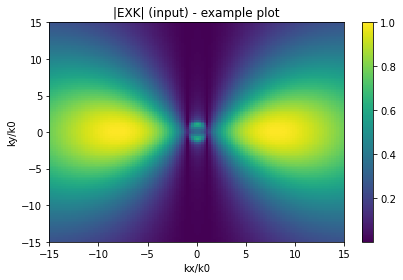

In [9]:
mp.dps=500              # number of significant figures
### moved these definitions to the top -- uncomment or change as needed
# f0=55.0e9             # frequency [Hz]
# p = [1, 0, 0]         # polarization of point dipole e.g. [1,0,0] x-polarized; [0,0,1] z-polarized
###

w=2*(np.pi)*f0          # angular frequency rad/s
lm=c0/f0                # wavelemgth [m]
k0=2.*(np.pi)/lm        # wavevector [rad/m]
d = lm/50               #  distance from point dipole at which we take the field [m]
N_tot = 2**9            # total number of points
N_lm_den = 125.0        # used for spatial resolution, in fraction of a wavelength
N_lm = 1./N_lm_den      # spatial resolution, in fraction of a wavelength. e.g. N_lm=1/10 --> dX = lm/10;

# define useful parameters and point dipole field
xx, yy, kxx, kyy, EX, EY, EZ, EXK, EYK, EZK = pd(f0,c0,d,N_tot,N_lm,p) # f0, c0, and p are defined in the first block of this Jupyter Notebook

### material parameters

# material 1 - air
epst1 = 1.;
epsz1 = 1;
L1 = 0.;          # Thickness of L1 (L1 = 0 if point source is in contact with hyperbolic medium)

# material 2 - uniaxial medium - COMSOL example
epst2 = (2.3104+0.006*1j)       # transverse permittivity
epsz2 = (-1.0e2+5.0e4*1j)      # transverse permeability
L2 = 3.4e-3               # Thickness of L2

# plot example component of field magnitude in k-space
plt.figure()
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,abs(EXK)/np.max(abs(EXK)))
axes = plt.gca()
plt.xlabel('kx/k0')
plt.ylabel('ky/k0')
axes.set_xlim([-15, 15])
axes.set_ylim([-15, 15])
plt.colorbar()
plt.title('|EXK| (input) - example plot')
plt.tight_layout()
plt.show()


In [10]:
# define vectors

k_parallel = np.sqrt(kxx**2+kyy**2)
k1z1, k1z2, k1z3, k1z4 = define_kiz_vectors(w,c0,kxx+0.0*1j,kyy+0.0*1j,epst1,epsz1)    # add a complex part to kxx and kyy so it doesn't return error
k2z1, k2z2, k2z3, k2z4 = define_kiz_vectors(w,c0,kxx+0.0*1j,kyy+0.0*1j,epst2,epsz2)    # add a complex part to kxx and kyy so it doesn't return error

k11 = define_ki_vector(kxx,kyy,k1z1);
k12 = define_ki_vector(kxx,kyy,k1z2);
k13 = define_ki_vector(kxx,kyy,k1z3);
k14 = define_ki_vector(kxx,kyy,k1z4);

k21 = define_ki_vector(kxx,kyy,k2z1);
k22 = define_ki_vector(kxx,kyy,k2z2);
k23 = define_ki_vector(kxx,kyy,k2z3);
k24 = define_ki_vector(kxx,kyy,k2z4);

# pre-allocate complex matrices

C=np.zeros((N_tot,N_tot,4,3))+0.0*1j        # change of basis
Cinv=np.zeros((N_tot,N_tot,3,4))+0.0*1j     # inverse change of basis

S=np.zeros((N_tot,N_tot,4,4))+0.0*1j        # total scattering matrix
S_mp=np.zeros((N_tot,N_tot,4,4))+0.0*1j     # total scattering matrix

CSC = np.zeros((N_tot,N_tot,3,3))+0.0*1j    # total transfer matrix
CSC_mp = np.zeros((N_tot,N_tot,3,3))+0.0*1j # total transfer matrix

EXK_out=np.zeros((N_tot,N_tot))+0.0*1j     # k-space field output x
EYK_out=np.zeros((N_tot,N_tot))+0.0*1j     # k-space field output y
EZK_out=np.zeros((N_tot,N_tot))+0.0*1j     # k-space field output z

# pre-allocate matrices, multi-precision

EXK_out_mp=np.zeros((N_tot,N_tot))+0.0*1j     # k-space field output x
EYK_out_mp=np.zeros((N_tot,N_tot))+0.0*1j     # k-space field output y
EZK_out_mp=np.zeros((N_tot,N_tot))+0.0*1j     # k-space field output z

# Eq. 31
StoOut_mp = mp.matrix([[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1],[0, 0, 0, 0]]);
StoOut = np.array([[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 1],[0, 0, 0, 0]]);

# define cartesian basis
ex = np.array([1, 0, 0])+0.0*1j
ey = np.array([0, 1, 0])+0.0*1j
ez = np.array([0, 0, 1])+0.0*1j

# define cartesian basis, multi-precision
ex_mp = mp.matrix([[mp.mpc('1'), 0, 0]])
ey_mp = mp.matrix([[0, mp.mpc('1'), 0]])
ez_mp = mp.matrix([[0, 0, mp.mpc('1')]])

#################### start the loop ####################
# both regular and multi-precision (*_mp) are calculated here, for comparison

for ki in range(0,N_tot):
    clear_output(wait=True)
    print(str(float(ki+1)/float(N_tot)*100)+"% complete")
    sys.stdout.flush()

    for kj in range(0,N_tot):
        # bases in medium 1, air, isotropic
        e11, e21, e31, e41 = TE_TM_e_bases(kxx[ki,kj],kyy[ki,kj],k_parallel[ki,kj],k1z3[ki,kj],k1z4[ki,kj],k13[ki,kj],k14[ki,kj])
        h11, h21, h31, h41 = TE_TM_h_bases_cross(w,kxx[ki,kj],kyy[ki,kj],k1z1[ki,kj],k1z2[ki,kj],k1z3[ki,kj],k1z4[ki,kj],e11,e21,e31,e41);
        # bases in medium 2, hyperbolic medium, anisotropic
        e12, e22, e32, e42 = TE_TM_e_bases_anisotropic(w,c0,kxx[ki,kj],kyy[ki,kj],k_parallel[ki,kj],k2z1[ki,kj],k2z2[ki,kj],k2z3[ki,kj],k2z4[ki,kj],k23[ki,kj],k24[ki,kj],epst2,epsz2);        
        h12, h22, h32, h42 = TE_TM_h_bases_cross(w,kxx[ki,kj],kyy[ki,kj],k2z1[ki,kj],k2z2[ki,kj],k2z3[ki,kj],k2z4[ki,kj],e12,e22,e32,e42);

# from here on we include multi-precision
# note that we are carrying machine precision accuracy to multiple precision

        e11_mp = mp.matrix(e11)
        e21_mp = mp.matrix(e21)
        e31_mp = mp.matrix(e31)
        e41_mp = mp.matrix(e41)
        e12_mp = mp.matrix(e12)
        e22_mp = mp.matrix(e22)
        e32_mp = mp.matrix(e32)
        e42_mp = mp.matrix(e42)

        h11_mp = mp.matrix(h11)
        h21_mp = mp.matrix(h21)
        h31_mp = mp.matrix(h31)
        h41_mp = mp.matrix(h41)
        h12_mp = mp.matrix(h12)
        h22_mp = mp.matrix(h22)
        h32_mp = mp.matrix(h32)
        h42_mp = mp.matrix(h42)	

        C[ki,kj,:,:], Cinv[ki,kj,:,:] = change_of_basis(ex,ey,ez,e11,e21,e31,e41);
        C_mp = mp.matrix(C[ki,kj,:,:])
        Cinv_mp  = mp.matrix(Cinv[ki,kj,:,:]) 
    
        D1 = D_matrix_dot_product(ex,ey,e11,e21,e31,e41,h11,h21,h31,h41)
        D2 = D_matrix_dot_product(ex,ey,e12,e22,e32,e42,h12,h22,h32,h42)
        D1_mp = mp.matrix(D1) 
        D2_mp = mp.matrix(D2) 

        P1 = P_matrix_complete(k1z1[ki,kj],k1z2[ki,kj],k1z3[ki,kj],k1z4[ki,kj],L1);
        P2 = P_matrix_complete(k2z1[ki,kj],k2z2[ki,kj],k2z3[ki,kj],k2z4[ki,kj],L2);

        # Propagation contains large exponentials and must be calculated with mp entirely -
        # it can't just be converted from machine precision
        
        P1_mp = P_matrix_complete_mp(k1z1[ki,kj],k1z2[ki,kj],k1z3[ki,kj],k1z4[ki,kj],L1)
        P2_mp = P_matrix_complete_mp(k2z1[ki,kj],k2z2[ki,kj],k2z3[ki,kj],k2z4[ki,kj],L2)

        # Equation 23 of https://doi.org/10.1038/srep17690
        M21 = np.dot(np.linalg.inv(D2),D1)
        M12 = np.dot(np.linalg.inv(D1),D2)
        M21_mp = D2_mp**-1*D1_mp
        M12_mp = D1_mp**-1*D2_mp 
        Q = np.dot(M12,np.dot(P2,M21))
        Q_mp = M12_mp*P2_mp*M21_mp

        # Use scattering matrix, see supplementary Material 1.1 of https://doi.org/10.1038/srep17690
        S[ki,kj,:,:] = scattering_matrix_4x4(Q)
        S_mp[ki,kj,:,:] = scattering_matrix_4x4_mp(Q_mp)

        # Obtain the fields at output in k-space
        EXK_out[ki,kj], EYK_out[ki,kj], EZK_out[ki,kj] = propagate_tot(EXK[ki,kj], EYK[ki,kj], EZK[ki,kj], C[ki,kj,:,:],Cinv[ki,kj,:,:], S[ki,kj,:,:])
        EXK_out_mp[ki,kj], EYK_out_mp[ki,kj], EZK_out_mp[ki,kj] = propagate_tot(EXK[ki,kj], EYK[ki,kj], EZK[ki,kj], C[ki,kj,:,:],Cinv[ki,kj,:,:], S_mp[ki,kj,:,:])
        
        # Or alternatively, get the transfer matrix only (Eq. 30)
        CSC[ki,kj,:,:]    = np.dot(Cinv[ki,kj,:,:],np.dot(StoOut,np.dot(S[ki,kj,:,:],C[ki,kj,:,:])));
        CSC_mp[ki,kj,:,:] = np.dot(Cinv[ki,kj,:,:],np.dot(StoOut,np.dot(S_mp[ki,kj,:,:],C[ki,kj,:,:])));

100.0% complete


In [21]:
# Obtain field in real space

# regular precision real space fields from FFT
EX_out = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(EXK_out)))
EY_out = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(EYK_out)))
EZ_out = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(EZK_out)))

# multi-precision real space fields from FFT
EX_out_mp = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(EXK_out_mp)))
EY_out_mp = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(EYK_out_mp)))
EZ_out_mp = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(EZK_out_mp)))

<ipython-input-30-63d6448845f2>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,2,kp)


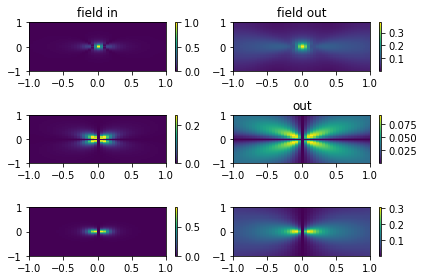

In [30]:
# real space field in and out - reproduces Fig. 3b, 3c, 4b, 4c depending on frequency and dipole orientation
plt.figure(1)
plt.subplot(3,2,1)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,np.abs(EX)/np.max(np.sqrt(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)))
plt.title('field in')
plt.subplot(3,2,3)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,np.abs(EY)/np.max(np.sqrt(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)))
plt.subplot(3,2,5)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,np.abs(EZ)/np.max(np.sqrt(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)))
plt.subplot(3,2,2)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,np.abs(EX_out_mp)/np.max(np.sqrt(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)))
plt.title('field out')
plt.subplot(3,2,4)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,np.abs(EY_out_mp)/np.max(np.sqrt(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)))
plt.title('out')
plt.subplot(3,2,6)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,np.abs(EZ_out_mp)/np.max(np.sqrt(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)))
for kp in range(1,7):
    plt.subplot(3,2,kp)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.colorbar()
    plt.tight_layout()
plt.show()

<ipython-input-34-eafa3c9a281e>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,kp)


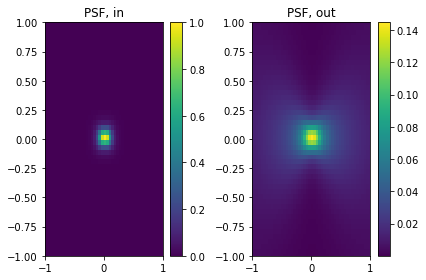

In [34]:
# point spread function - in and out - reproduces Fig. 5 depending on frequency and dipole orientation
plt.figure(2)
plt.subplot(1,2,1)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2)/np.max(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2))
plt.title('PSF, in')
plt.subplot(1,2,2)
plt.pcolormesh(np.real(xx)/1e-3,np.real(yy)/1e-3,(np.abs(EX_out_mp)**2+np.abs(EY_out_mp)**2+np.abs(EZ_out_mp)**2)/np.max(np.abs(EX)**2+np.abs(EY)**2+np.abs(EZ)**2))
plt.title('PSF, out')
for kp in range(1,3):
    plt.subplot(1,2,kp)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.colorbar()
    plt.tight_layout()
plt.show()

<ipython-input-35-1c9a8c7038b4>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,kp)


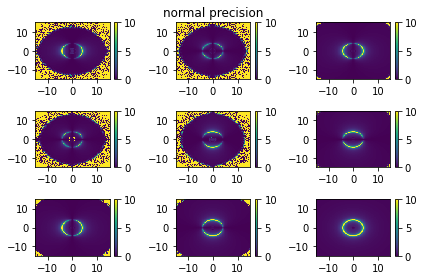

<ipython-input-35-1c9a8c7038b4>:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,kp)


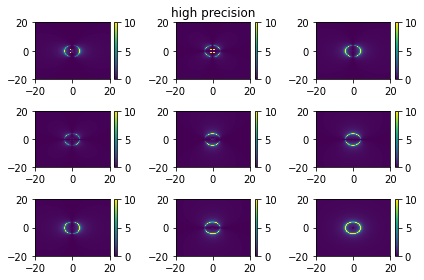

In [35]:
# transfer matrix - this reproduces Fig. 3a or 4a depending on frequency and dipole orientation

cb_min = 0  # colorbar limit is 0
cb_max = 10 # colorbar limit for f0 = 55GHz
#cb_max = 1.5 # colorbar limit for f0 = 58GHz

# normal precision to show the importance of mpmath
plt.figure(3)
plt.subplot(3,3,1)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,0,0]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,2)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,0,1]),vmin=cb_min, vmax=cb_max)
plt.title('normal precision')
plt.subplot(3,3,3)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,0,2]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,4)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,1,0]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,5)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,1,1]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,6)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,1,2]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,7)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,2,0]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,8)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,2,1]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,9)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC[:,:,2,2]),vmin=cb_min, vmax=cb_max)
for kp in range(1,10):
    plt.subplot(3,3,kp)
    plt.xlim([-15,15])
    plt.ylim([-15,15])
    plt.colorbar()
    plt.tight_layout()
plt.show()

# high precision to show the importance of mpmath
plt.figure(5) 
plt.subplot(3,3,1)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,0,0]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,2)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,0,1]),vmin=cb_min, vmax=cb_max)
plt.title('high precision')
plt.subplot(3,3,3)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,0,2]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,4)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,1,0]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,5)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,1,1]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,6)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,1,2]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,7)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,2,0]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,8)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,2,1]),vmin=cb_min, vmax=cb_max)
plt.subplot(3,3,9)
plt.pcolormesh(np.real(kxx)/k0,np.real(kyy)/k0,np.abs(CSC_mp[:,:,2,2]),vmin=cb_min, vmax=cb_max)
for kp in range(1,10):
    plt.subplot(3,3,kp)
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.colorbar()
    plt.tight_layout()
plt.show()